<a href="https://colab.research.google.com/github/PulkitAppz/Capstone_AIML_19B/blob/Pulkit/CapStone_Submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT DESCRIPTION**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.
In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.



Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.


Details about the data and dataset files are given in below link,
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data



In [3]:
# Installing pydicom to read dcm files
!pip install -q pydicom

     |████████████████████████████████| 35.5MB 1.2MB/s 


In [4]:
# Import necessary packages/Library
import pydicom as dcm
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, zipfile, random, csv
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Set path to G-Drive
from google.colab import drive
drive.mount('/content/drive')
print(os. getcwd())
print(os.listdir())
os.chdir('/content/drive/My Drive/Colab Notebooks/Capstone')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
['.config', 'drive', 'sample_data']


**Download Dataset**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pulkitswami7","key":"0396ff6b1c433f1ef961d8233d7ee37d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
'chmod 600 /root/.kaggle/kaggle.json'

'chmod 600 /root/.kaggle/kaggle.json'

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c rsna-pneumonia-detection-challenge

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
100% 3.66G/3.66G [00:49<00:00, 6.44MB/s]
100% 3.66G/3.66G [00:49<00:00, 80.1MB/s]


In [6]:
!ls


CapStone_Submission1.ipynb  kaggle.json  rsna-pneumonia-detection-challenge.zip


In [7]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
files = zipfile.ZipFile(file_name, 'r')
files.extractall()

In [8]:
!ls


 CapStone_Submission1.ipynb		  stage_2_sample_submission.csv
'GCP Credits Request Link - RSNA.txt'	  stage_2_test_images
 kaggle.json				  stage_2_train_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


**Exploring CSVs**

1. Images for the current stage in the stage_2_train_images and stage_2_test_images.

2. Training data: stage_2_train_labels.csv

3. stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [10]:
print('***'*10, 'Datasets Summary', '***'*10)
train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')#(0 for rows and 1 for columns)
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')


****************************** Datasets Summary ******************************
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns


From above Output, we can say there is 30227 patients IDs or may be there is duplicate patient IDs. So, lets check below, if there is any duplicate IDs.

In [15]:
print('No. of Unique patient IDs in train_labels:', train_labels['patientId'].nunique() )
print('No. of Unique patient IDs in class_info:', class_info['patientId'].nunique() )

Unique patient IDs in train_labels 26684
Unique patient IDs in class_info 26684


In [19]:
print('No. of Duplicate Ids:{}' .format((30227)-(train_labels['patientId'].nunique())) )

No. of Duplicate Ids:3543


**Exploratory Data Analysis (EDA)**


In [20]:
train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [21]:
class_info.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [25]:
import glob
imgArr = list(set(glob.glob('stage_2_train_images/'+'*.dcm')))

In [26]:
imgArr[0]

'stage_2_train_images/5b0c3016-c88d-4b19-82f8-bee204b8e12c.dcm'

size of DCM images is: 1024 x 1024


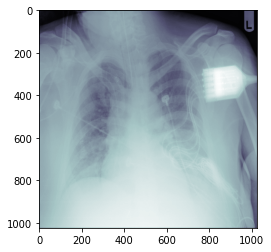

In [29]:
img=dcm.dcmread(imgArr[5])
if 'PixelData' in img:
    rows = int(img.Rows)
    cols = int(img.Columns)
    print("size of DCM images is: {rows:d} x {cols:d}".format(rows=rows, cols=cols))
plt.imshow(img.pixel_array,cmap=plt.cm.bone)
plt.show()

In [30]:
img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.17436.1517874404.70798
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.17436.1517874404.70798
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        